In [9]:
import cv2
import numpy as np
import os
import shutil
from pycocotools.coco import COCO
import json
import pypinyin

def to_pinyin(text):
    return ''.join(pypinyin.lazy_pinyin(text))

def mkr(path):
    """Create a directory. If it exists, delete and recreate it."""
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)

def mask_generator(coco, image_id, classes_names):
    """Generate a mask image for the specified COCO image ID and classes, and return the classes."""
    img_info = coco.loadImgs(image_id)[0]
    width, height = img_info['width'], img_info['height']
    mask_pic = np.zeros((height, width), dtype=np.uint8)
    present_classes = []

    cat_ids = coco.getCatIds(catNms=classes_names)
    ann_ids = coco.getAnnIds(imgIds=image_id, catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        class_id = ann['category_id']
        # Make sure to retrieve class name in a safe format
        class_name = coco.loadCats(class_id)[0]['name']
        # Convert to a string, if it's not already one
        class_name_str = str(class_name)
        # Append the class name if it's not already present in the list
        if class_name_str not in present_classes:
            present_classes.append(class_name_str)
        mask_value=0
        if class_name_str == '新生物':
            mask_value = 1
        elif class_name_str == '出血':
            mask_value = 2    
        elif class_name_str == '黄痰':
            mask_value = 3
        elif class_name_str == '堵塞':
            mask_value = 4
        elif class_name_str == '粗糙':
            mask_value = 5
        mask_pic = np.maximum(mask_pic, coco.annToMask(ann) * mask_value)

    #thresh1, dst = cv2.threshold(mask_pic, 127, 255, cv2.THRESH_BINARY)
    # Resize to 255x255
    #dst = cv2.resize(dst, (255, 255), interpolation=cv2.INTER_NEAREST)

    return mask_pic, present_classes


def find_image_path(image_dirs, filename):
    """Find the path of an image in a list of directories."""
    for dir in image_dirs:
        potential_path = os.path.join(dir, filename)
        if os.path.isfile(potential_path):
            return potential_path
    return None

def save_masks(coco, dataset_dir, classes_names, dataset_name, image_dirs):
    """Save binary masks and original images for all images in the specified COCO dataset including class names."""
    all_image_ids = coco.getImgIds()
    images_with_annotations = 0

    for image_id in all_image_ids:
        mask, present_classes = mask_generator(coco, image_id, classes_names)
        if present_classes:
            images_with_annotations += 1
            class_names_str = '_'.join([to_pinyin(cn) for cn in present_classes])

            # Filename for the mask
            mask_filename = f"{dataset_dir}/{dataset_name}_{class_names_str}_{image_id}_mask.png"
            cv2.imwrite(mask_filename, mask)
            verify_saved_mask(mask_filename)

            # Find and save the original image
            img_info = coco.loadImgs(image_id)[0]
            original_image_path = find_image_path(image_dirs, img_info['file_name'])
            if original_image_path:
                original_image_filename = f"{dataset_dir}/{dataset_name}_{class_names_str}_{image_id}.png"
                shutil.copyfile(original_image_path, original_image_filename)

    print(f"Found and saved masks and original images for {images_with_annotations} images with specified class annotations.")


def verify_saved_mask(mask_path):
    """Verify if the saved mask is a single-channel image and its dimensions."""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Error: The mask at {mask_path} could not be read.")

def process_dataset(annotation_file_path, dataset_dir, classes_names, image_dirs):
    """Load the dataset and process all images."""
    with open(annotation_file_path, 'r', encoding='utf-8') as f:
        dataset = json.load(f)
    coco = COCO()
    coco.dataset = dataset
    coco.createIndex()

    dataset_name = annotation_file_path.split('/')[1]

    # Generate and save masks and original images
    save_masks(coco, dataset_dir, classes_names, dataset_name, image_dirs)



# Configuration
annotation_files  = ["./20230728_094323/annotations/instances_default.json",
                     "./20230728_083801/annotations/instances_default.json",
                     "./20230728_111620/annotations/instances_default.json",
                     "./20230714_103330/annotations/instances_default.json",
                     "./20230714_113213 (1)/annotations/instances_default.json",
                     "./20230728_092252/annotations/instances_default.json",
                     "./20230728_100941/annotations/instances_default.json",
                     "./20230728_114311 (1)/annotations/instances_default.json"]
save_path = "./coco_mask/"
classes_names = ['新生物','出血','糜烂','粗糙','黄痰','堵塞']

# Make sure the dataset directory exists
mkr(save_path)

original_image_dirs = ["./20230728_094323/images",
                     "./20230728_083801/images",
                     "./20230728_111620/images",
                     "./20230714_103330/images",
                     "./20230714_113213 (1)/images",
                     "./20230728_092252/images",
                     "./20230728_100941/images",
                     "./20230728_114311 (1)/images"]

for annotation_file in annotation_files:
    process_dataset(annotation_file, save_path, classes_names, original_image_dirs)
    

creating index...
index created!
Found and saved masks and original images for 129 images with specified class annotations.
creating index...
index created!


KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np

def display_unique_mask_values(mask_path):
    # Load the mask image
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        print("Error loading image")
        return

    # Find unique values in the mask
    unique_values = np.unique(mask)

    # Print the unique values
    print("Unique values in the mask:", unique_values)

# Example usage
#mask_path = './coco_mask/20230728_100941_duse_8070_mask.png'
mask_path='./coco_mask/20230728_114311 (1)_xinshengwu_chuxue_7904_mask.png'
display_unique_mask_values(mask_path)


Unique values in the mask: [0 1 2]


In [ ]:
from PIL import Image
import numpy as np

def crop_and_resize(image, left, top, right, bottom):
    # Crop the image and resize it to new dimensions
    cropped_image = image.crop((left, top, right, bottom))
    #cropped_image=cv2.resize(cropped_image, (255, 255), interpolation=cv2.INTER_NEAREST)
    cropped_image = cropped_image.resize((255, 255), Image.Resampling.LANCZOS)
    return cropped_image

# Load the image from the provided path
image_path = './coco_mask/20230714_103330_chuxue_856.png'  # Replace with your image path
image = Image.open(image_path)

# Define the square size and position
height, width = image.size
square_size = int(min(height, width // 1))  # The size will be a quarter of the image width
cx = (3 * width // 2) - (width // 4)  # Move to the left within the right half
cy = height // 2.5  # Center of the height

# Calculate the square coordinates
left = int(cx - square_size // 2.2)
top = int(cy - square_size // 1.6)
right = int(cx + square_size // 2.8)
bottom = int(cy + square_size // 5)

# Crop and resize the image
cropped_resized_image = crop_and_resize(image, left, top, right, bottom)

# Save the cropped and resized part of the image
output_image_path = './shifted_square_image.png'  # Replace with your desired save path
cropped_resized_image.save(output_image_path)

# Optionally, display the path to the saved image
print(f'Saved shifted square image at: {output_image_path}')

Saved shifted square image at: ./shifted_square_image.png


In [ ]:
from PIL import Image
import os

def crop_and_resize(image, left, top, right, bottom):
    # Crop the image
    cropped_image = image.crop((left, top, right, bottom))
    # Resize the cropped image to 255x255 pixels
    resized_image = cropped_image.resize((255, 255), Image.Resampling.LANCZOS)
    return resized_image

def process_image(image_path, output_folder):
    # Load the image
    image = Image.open(image_path)

    # Define the square size and position
    height, width = image.size
    square_size = int(min(height, width // 1))  # The size will be a half of the image width
    cx = (3 * width // 2) - (width // 4)  # Move to the left within the right half
    cy = height // 2.5  # Center of the height

    # Calculate the square coordinates
    left = int(cx - square_size // 2.2)
    top = int(cy - square_size // 1.6)
    right = int(cx + square_size // 2.8)
    bottom = int(cy + square_size // 5)

    # Crop and resize the image
    cropped_resized_image = crop_and_resize(image, left, top, right, bottom)

    # Save the cropped and resized part of the image
    image_filename = os.path.basename(image_path)
    output_image_path = os.path.join(output_folder, image_filename)
    cropped_resized_image.save(output_image_path)

# Path to the input and output directories
input_folder = './coco_mask'
output_folder = './coco_mask_cropped'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process each image in the input folder
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png')):
        image_path = os.path.join(input_folder, filename)
        process_image(image_path, output_folder)
        print(f'Processed {filename}')


Processed 20230714_103330_chuxue_1002.png
Processed 20230714_103330_chuxue_1002_mask.png
Processed 20230714_103330_chuxue_1008.png
Processed 20230714_103330_chuxue_1008_mask.png
Processed 20230714_103330_chuxue_1159.png
Processed 20230714_103330_chuxue_1159_mask.png
Processed 20230714_103330_chuxue_856.png
Processed 20230714_103330_chuxue_856_mask.png
Processed 20230714_103330_chuxue_864.png
Processed 20230714_103330_chuxue_864_mask.png
Processed 20230714_103330_chuxue_875.png
Processed 20230714_103330_chuxue_875_mask.png
Processed 20230714_103330_chuxue_882.png
Processed 20230714_103330_chuxue_882_mask.png
Processed 20230714_103330_chuxue_897.png
Processed 20230714_103330_chuxue_897_mask.png
Processed 20230714_103330_chuxue_936.png
Processed 20230714_103330_chuxue_936_mask.png
Processed 20230714_103330_chuxue_981.png
Processed 20230714_103330_chuxue_981_mask.png
Processed 20230714_103330_duse_5988.png
Processed 20230714_103330_duse_5988_mask.png
Processed 20230714_103330_duse_6002.png

[[671, 209, 670, 208, 670, 207, 669, 206, 669, 204, 668, 203, 668, 200, 664, 196, 664, 194, 662, 192, 662, 191, 658, 187, 653, 187, 650, 190, 650, 191, 649, 192, 644, 192, 642, 194, 641, 194, 640, 195, 637, 195, 635, 197, 634, 197, 633, 198, 631, 198, 630, 199, 628, 199, 627, 200, 626, 200, 625, 201, 624, 201, 623, 202, 622, 202, 620, 204, 618, 204, 613, 209, 610, 209, 601, 218, 601, 219, 596, 224, 596, 229, 599, 232, 602, 232, 603, 233, 603, 235, 605, 237, 605, 238, 609, 242, 611, 242, 613, 244, 617, 244, 621, 248, 622, 248, 623, 249, 627, 249, 629, 251, 631, 251, 632, 252, 633, 252, 634, 253, 646, 253, 650, 257, 655, 257, 658, 254, 658, 251, 661, 248, 661, 246, 662, 245, 662, 243, 664, 241, 664, 240, 666, 238, 666, 237, 667, 236, 667, 235, 668, 234, 668, 233, 670, 231, 670, 230, 671, 229, 671, 228, 672, 227, 672, 216, 671, 215]]


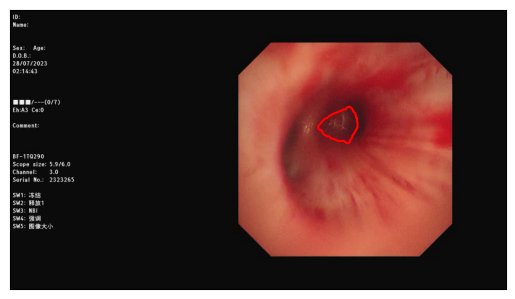

In [53]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 假设 polygon_coords 是你从 RLE 转换得到的多边形坐标
# 这里是一个示例，你应该用上一个脚本得到的真实数据
import cv2
import numpy as np
from pycocotools import mask

import cv2
import numpy as np
from pycocotools import mask as maskUtils

def rle2polygon(segmentation, h, w):
    """
    Converts RLE encoding to polygon coordinates.
    """
    # Convert the uncompressed RLE to compressed RLE using frPyObjects
    rle = maskUtils.frPyObjects([segmentation], h, w)
    compressed_rle = maskUtils.merge(rle)
    
    # Decode the mask
    m = maskUtils.decode(compressed_rle) 
    m[m > 0] = 255

    # Find contours from the mask
    contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        # Simplify the contour to get polygon vertices
        epsilon = 0.001 * cv2.arcLength(contour, True)
        contour_approx = cv2.approxPolyDP(contour, epsilon, True)
        # Flatten and convert to list
        polygon = contour_approx.flatten().tolist()
        polygons.append(polygon)
    return polygons


# 你的COCO数据
coco_data = {
    "id": 69,
    "image_id": 2136,
    "category_id": 1,
    "segmentation": {
        "counts": [322064, 6, 533, 8, 531, 10, 529, 12, 527, 13, 525, 15, 524, 16, 523, 20, 519, 22, 517, 25, 514, 27, 512, 29, 510, 31, 508, 33, 506, 34, 506, 34, 506, 35, 505, 36, 503, 37, 502, 38, 501, 39, 500, 40, 499, 42, 498, 43, 497, 44, 495, 46, 493, 47, 493, 48, 491, 49, 491, 49, 490, 50, 490, 50, 489, 52, 488, 53, 487, 53, 486, 54, 486, 55, 485, 55, 484, 57, 483, 57, 482, 58, 481, 59, 481, 59, 481, 59, 481, 59, 480, 60, 480, 60, 479, 61, 478, 62, 478, 62, 478, 62, 478, 63, 477, 64, 476, 65, 473, 68, 471, 69, 470, 70, 469, 71, 469, 71, 469, 71, 469, 70, 470, 69, 471, 68, 473, 63, 478, 61, 480, 59, 482, 55, 487, 50, 491, 48, 495, 43, 498, 41, 500, 38, 503, 35, 509, 29, 514, 25, 517, 21, 526, 12, 155292],
        "size": [540, 960]
    },
    "area": 3524.0,
    "bbox": [596.0, 187.0, 77.0, 71.0],
    "iscrowd": 1,
    "attributes": {"occluded": False}
}

# 将RLE编码转换为多边形坐标
h, w = coco_data['segmentation']['size']
polygon_coords = rle2polygon(coco_data['segmentation'], h, w)

# 打印多边形坐标
print(polygon_coords)


import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load your image
image_path = "C:/Users/z8443/Downloads/20230728_094323/images/33060.png"
image = Image.open(image_path)

# Create a matplotlib figure with the image
fig, ax = plt.subplots()
ax.imshow(image)

# Loop through all polygon coordinates and draw them
for polygon in polygon_coords:
    # Split the coordinates into x and y values
    x_coords = polygon[0::2]  # Even indices
    y_coords = polygon[1::2]  # Odd indices

    # Close the polygon by adding the first point at the end
    x_coords.append(x_coords[0])
    y_coords.append(y_coords[0])

    # Draw the polygon
    ax.plot(x_coords, y_coords, color='red')  # You can change the color if needed

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Show the image with the polygons
plt.show()


In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Given COCO format segmentation data
segmentation = {
    "counts": [525,16,523,18,521,23,516,26,513,31,508,33,505,36,503,38,501,40,499,42,498,42,498,43,496,45,495,45,494,47,493,47,492,49,491,49,491,49,490,50,491,49,491,49,491,49,490,50,489,51,488,52,488,52,487,53,486,54,485,55,485,55,484,56,484,56,483,57,482,58,482,58,481,59,481,59,480,60,480,61,478,62,478,62,478,62,478,62,478,62,477,63,476,64,476,64,476,64,476,64,475,65,475,65,475,66,474,66,474,66,474,67,473,67,473,67,473,68,472,68,472,68,472,68,472,68,473,67,473,67,472,69,471,69,471,69,471,69,471,69,470,70,470,70,469,71,469,71,469,71,469,71,469,71,469,71,468,72,467,73,467,73,467,73,467,73,466,74,466,74,465,75,464,76,464,76,464,76,464,76,464,76,464,76,464,76,465,75,466,74,467,73,467,73,468,72,469,71,470,5,2,63,478,62,479,12,4,45,498,42,502,38,504,36,509,31,512,27,516,23,521,18,524,14],  # Full counts array goes here
    "size": [960, 540]
}

height, width = segmentation['size']
segmentation_counts = segmentation['counts']


In [35]:
print(len(segmentation_counts))
# Decoding the points from the RLE counts
points = []
for i in range(0, len(segmentation_counts), 2):
    points.append((segmentation_counts[i], segmentation_counts[i+1]))


224


In [36]:
points

[(525, 16),
 (523, 18),
 (521, 23),
 (516, 26),
 (513, 31),
 (508, 33),
 (505, 36),
 (503, 38),
 (501, 40),
 (499, 42),
 (498, 42),
 (498, 43),
 (496, 45),
 (495, 45),
 (494, 47),
 (493, 47),
 (492, 49),
 (491, 49),
 (491, 49),
 (490, 50),
 (491, 49),
 (491, 49),
 (491, 49),
 (490, 50),
 (489, 51),
 (488, 52),
 (488, 52),
 (487, 53),
 (486, 54),
 (485, 55),
 (485, 55),
 (484, 56),
 (484, 56),
 (483, 57),
 (482, 58),
 (482, 58),
 (481, 59),
 (481, 59),
 (480, 60),
 (480, 61),
 (478, 62),
 (478, 62),
 (478, 62),
 (478, 62),
 (478, 62),
 (477, 63),
 (476, 64),
 (476, 64),
 (476, 64),
 (476, 64),
 (475, 65),
 (475, 65),
 (475, 66),
 (474, 66),
 (474, 66),
 (474, 67),
 (473, 67),
 (473, 67),
 (473, 68),
 (472, 68),
 (472, 68),
 (472, 68),
 (472, 68),
 (473, 67),
 (473, 67),
 (472, 69),
 (471, 69),
 (471, 69),
 (471, 69),
 (471, 69),
 (470, 70),
 (470, 70),
 (469, 71),
 (469, 71),
 (469, 71),
 (469, 71),
 (469, 71),
 (469, 71),
 (468, 72),
 (467, 73),
 (467, 73),
 (467, 73),
 (467, 73),
 (46

In [37]:

from PIL import Image, ImageDraw


# 打开图片
img = Image.open("C:/Users/z8443/Downloads/20230728_094323/images/37644.png")

# 创建一个用于绘制的对象
draw = ImageDraw.Draw(img)

# 点的大小
point_size = 5

# 在图片上绘制每个点
for point in points:
    # 计算点的左上角和右下角坐标，用于绘制矩形（即“点”）
    x, y = point
    bbox = [x - point_size, y - point_size, x + point_size, y + point_size]
    draw.ellipse(bbox, fill='red')  # 你可以选择你喜欢的颜色

# 保存或显示图片
img.show()  # 直接显示图片
# img.save("output.png")  # 或者保存到文件
